In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meryemechbab","key":"d682417b3afb1bdb93a4ba46850d90c2"}'}

In [ ]:
# 1. Créer un dossier nommé `data`
!mkdir -p data




In [ ]:
# Créer le dossier kaggle
!mkdir -p ~/.kaggle

# Déplacer kaggle.json au bon endroit
!mv kaggle.json ~/.kaggle/

# Donner les bons droits
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d orvile/annotated-ultrasound-liver-images-dataset
!unzip annotated-ultrasound-liver-images-dataset.zip -d data


Dataset URL: https://www.kaggle.com/datasets/orvile/annotated-ultrasound-liver-images-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/67.1M [00:00<?, ?B/s]
100% 67.1M/67.1M [00:00<00:00, 1.15GB/s]
Archive:  annotated-ultrasound-liver-images-dataset.zip
  inflating: data/7272660/Benign/Benign/image/1.jpg  
  inflating: data/7272660/Benign/Benign/image/10.jpg  
  inflating: data/7272660/Benign/Benign/image/100.jpg  
  inflating: data/7272660/Benign/Benign/image/101.jpg  
  inflating: data/7272660/Benign/Benign/image/102.jpg  
  inflating: data/7272660/Benign/Benign/image/103.jpg  
  inflating: data/7272660/Benign/Benign/image/104.jpg  
  inflating: data/7272660/Benign/Benign/image/105.jpg  
  inflating: data/7272660/Benign/Benign/image/106.jpg  
  inflating: data/7272660/Benign/Benign/image/107.jpg  
  inflating: data/7272660/Benign/Benign/image/108.jpg  
  inflating: data/7272660/Benign/Benign/image/109.jpg  
  inflating: data/7272660/Benign/Benign/image/11.jpg  

# Bloc 1 : Chargement + prétraitement + division en train/val/test + affichage d'images

Total d'images chargées : 735


Train : 530, Validation : 94, Test : 111


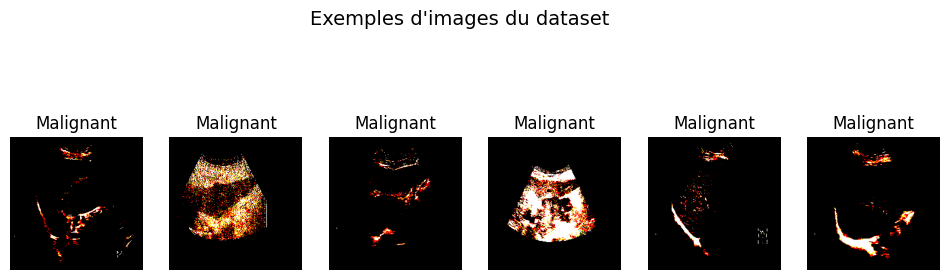

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# === PARAMÈTRES ===
base_path = "data/7272660"
classes = ['Normal', 'Benign', 'Malignant']
img_size = (224, 224)

# === CHARGEMENT DES IMAGES ===
X = []
y = []

for idx, label in enumerate(classes):
    img_dir = os.path.join(base_path, label, label, "image")
    for fname in os.listdir(img_dir):
        if fname.endswith(".jpg"):
            img_path = os.path.join(img_dir, fname)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            X.append(img_array)
            y.append(idx)

X = np.array(X)
y = np.array(y)

print("Total d'images chargées :", len(X))

# === DIVISION EN TRAIN / VALID / TEST ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, stratify=y_temp, random_state=42)

print(f"Train : {len(X_train)}, Validation : {len(X_val)}, Test : {len(X_test)}")

# === AFFICHER QUELQUES IMAGES ===
def show_images(X, y, n=6):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow((X[i] + 1) / 2)  # inverser preprocess_input()
        plt.title(classes[y[i]])
        plt.axis("off")
    plt.suptitle("Exemples d'images du dataset", fontsize=14)
    plt.show()

show_images(X_train, y_train)


# BLOC 2 : Extraction des features via ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

# === Initialisation du modèle ResNet50 ===
resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
resnet_model.trainable = False  # gel des poids

# === Extraction des vecteurs de caractéristiques ===
features_train = resnet_model.predict(X_train, verbose=1)
features_val = resnet_model.predict(X_val, verbose=1)
features_test = resnet_model.predict(X_test, verbose=1)

print("Taille des features (train) :", features_train.shape)


17/17 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step
Taille des features (train) : (530, 2048)


# BLOC 3A : Classification avec SVM + régularisation + évaluation

=== Rapport de classification SVM ===
              precision    recall  f1-score   support

      Normal       0.55      0.73      0.63        15
      Benign       0.46      0.37      0.41        30
   Malignant       0.81      0.82      0.81        66

    accuracy                           0.68       111
   macro avg       0.60      0.64      0.62       111
weighted avg       0.68      0.68      0.68       111

F1-score macro : 0.6160029703889353
Accuracy : 0.6846846846846847


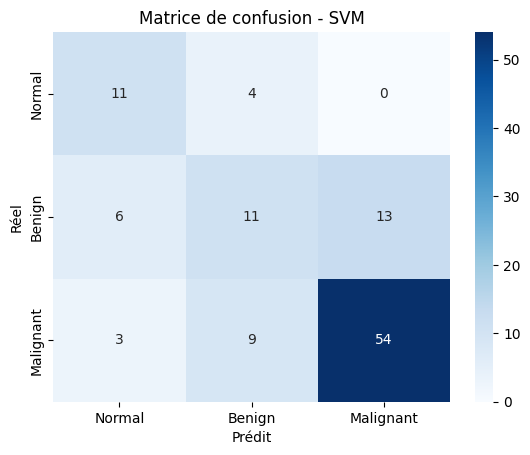

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# === SVM avec régularisation (C = 1.0 est par défaut) ===
svm = SVC(kernel='linear', C=1.0)
svm.fit(features_train, y_train)

# === Prédiction et évaluation ===
y_pred = svm.predict(features_test)

print("=== Rapport de classification SVM ===")
print(classification_report(y_test, y_pred, target_names=classes))
print("F1-score macro :", f1_score(y_test, y_pred, average='macro'))
print("Accuracy :", accuracy_score(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - SVM")
plt.show()


# BLOC 3B (optionnel) : Classifier avec MLP (réseau de neurones dense)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4598 - loss: 1.4954 - val_accuracy: 0.5851 - val_loss: 0.7592 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5091 - loss: 1.0471 - val_accuracy: 0.6809 - val_loss: 0.7305 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6124 - loss: 0.8157 - val_accuracy: 0.7234 - val_loss: 0.6663 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6696 - loss: 0.7466 - val_accuracy: 0.7128 - val_loss: 0.6435 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6475 - loss: 0.7474 - val_accuracy: 0.7128 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6722 - loss: 0.6817 - val_accuracy: 0.7234 - val_loss: 0.6169 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6979 - loss: 0.6709 - val_acc

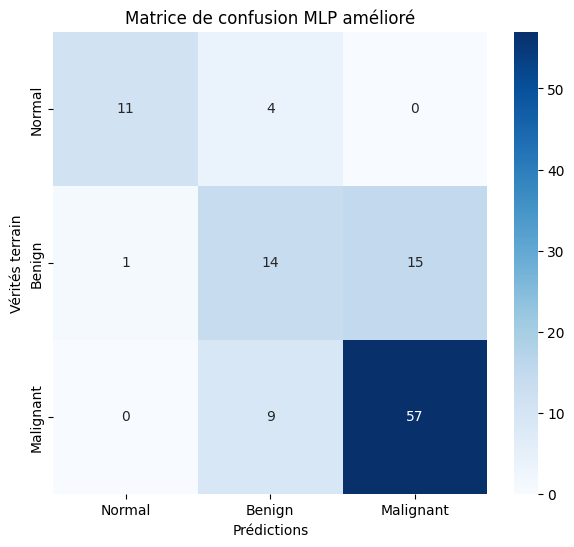

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 1. One-hot encoding des labels
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# 2. Définition du modèle MLP amélioré
mlp = Sequential([
    Dense(256, activation='relu', input_shape=(features_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# 3. Compilation du modèle avec un taux d’apprentissage ajusté
optimizer = Adam(learning_rate=0.001)
mlp.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Callbacks pour stopper si overfitting + ajuster le learning rate automatiquement
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# 5. Entraînement du modèle
history = mlp.fit(
    features_train, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(features_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

# 6. Évaluation sur le jeu de test
test_loss, test_acc = mlp.evaluate(features_test, y_test_cat)
print(f"✅ Accuracy MLP amélioré : {test_acc:.4f}")

# 7. Prédictions et rapport de classification
y_pred_mlp = np.argmax(mlp.predict(features_test), axis=1)
print("=== Rapport de classification MLP Amélioré ===")
print(classification_report(y_test, y_pred_mlp, target_names=classes))
# 8. Matrice de confusion
cm = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.title('Matrice de confusion MLP amélioré')
plt.show()

 Random Forest Classifier (RF)

=== Rapport de classification - Random Forest ===
              precision    recall  f1-score   support

      Normal       0.82      0.60      0.69        15
      Benign       0.61      0.37      0.46        30
   Malignant       0.74      0.92      0.82        66

    accuracy                           0.73       111
   macro avg       0.72      0.63      0.66       111
weighted avg       0.72      0.73      0.71       111



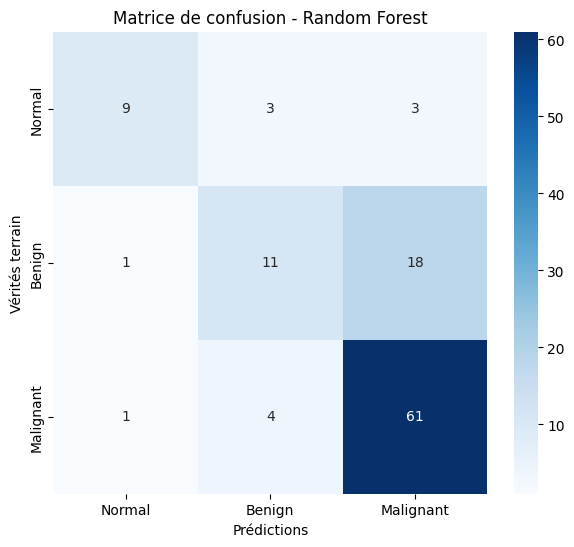

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Entraînement
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_train, y_train)

# Prédiction
y_pred_rf = rf.predict(features_test)

# Évaluation
print("=== Rapport de classification - Random Forest ===")
print(classification_report(y_test, y_pred_rf, target_names=classes))
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.title('Matrice de confusion - Random Forest')
plt.show()

k-Nearest Neighbors (k-NN)

=== Rapport de classification - k-NN ===
              precision    recall  f1-score   support

      Normal       0.67      0.67      0.67        15
      Benign       0.55      0.40      0.46        30
   Malignant       0.78      0.88      0.83        66

    accuracy                           0.72       111
   macro avg       0.67      0.65      0.65       111
weighted avg       0.70      0.72      0.71       111



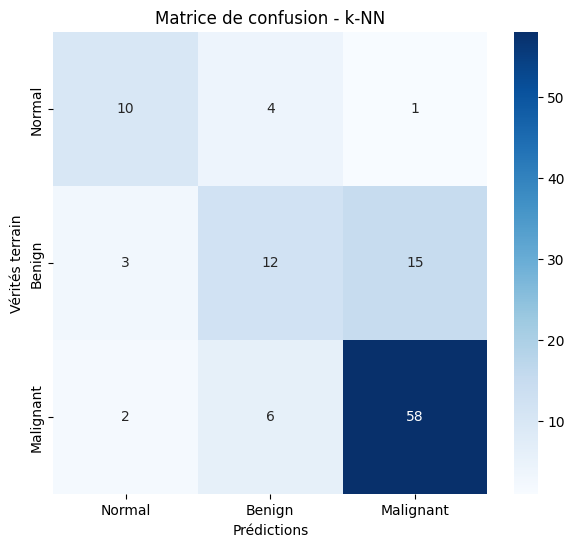

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Entraînement
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(features_train, y_train)

# Prédiction
y_pred_knn = knn.predict(features_test)

# Évaluation
print("=== Rapport de classification - k-NN ===")
print(classification_report(y_test, y_pred_knn, target_names=classes))
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.title('Matrice de confusion - k-NN')
plt.show()

QUELQUE AFFICHAGE ALEATOIRE


In [ ]:
def plot_predictions_mixed(model_name, y_true, y_pred, X_data, classes, n=10):
    import random
    import matplotlib.pyplot as plt

    indices = list(range(len(y_true)))
    random.shuffle(indices)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices[:n]):
        plt.subplot(2, 5, i+1)
        plt.imshow((X_data[idx] + 1) / 2)
        correct = (y_pred[idx] == y_true[idx])
        status = "✅ Correct" if correct else "❌ Faux"
        plt.title(f"{status}\nRéel: {classes[y_true[idx]]}\nPrévu: {classes[y_pred[idx]]}")
        plt.axis("off")
    plt.suptitle(f"{n} images (mélange correct/faux) - {model_name}", fontsize=16)
    plt.tight_layout()
    plt.show()


<ipython-input-45-1129814933>:17: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-45-1129814933>:17: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


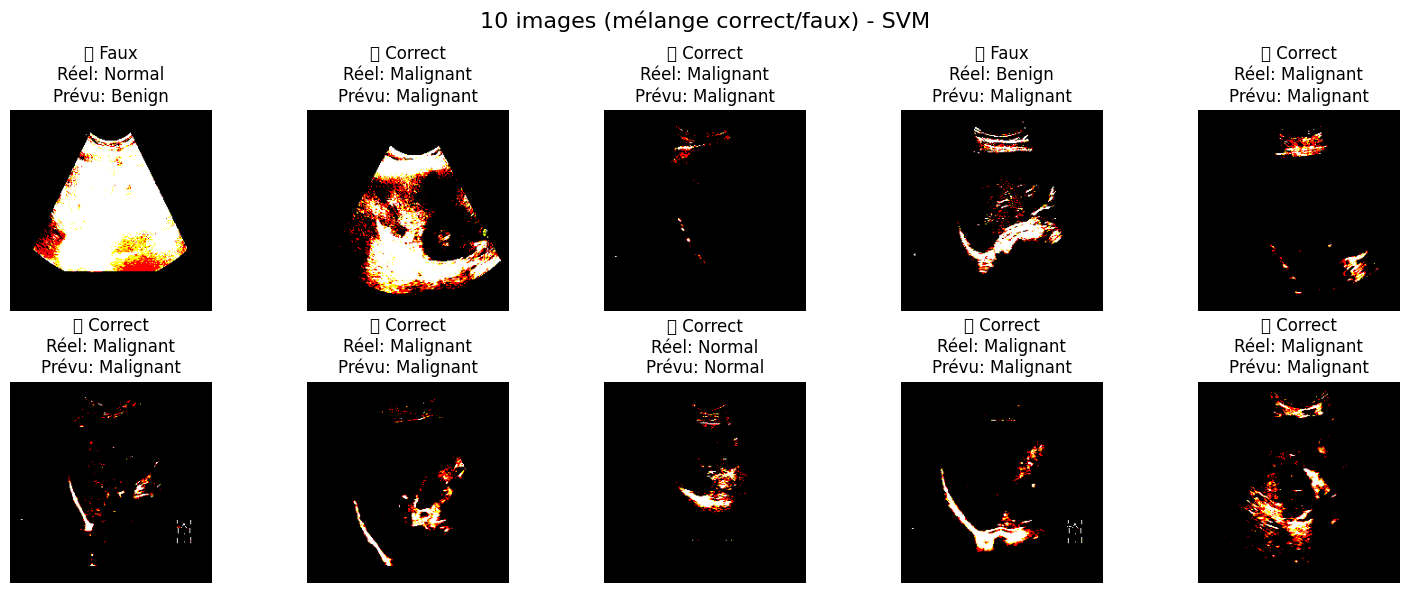

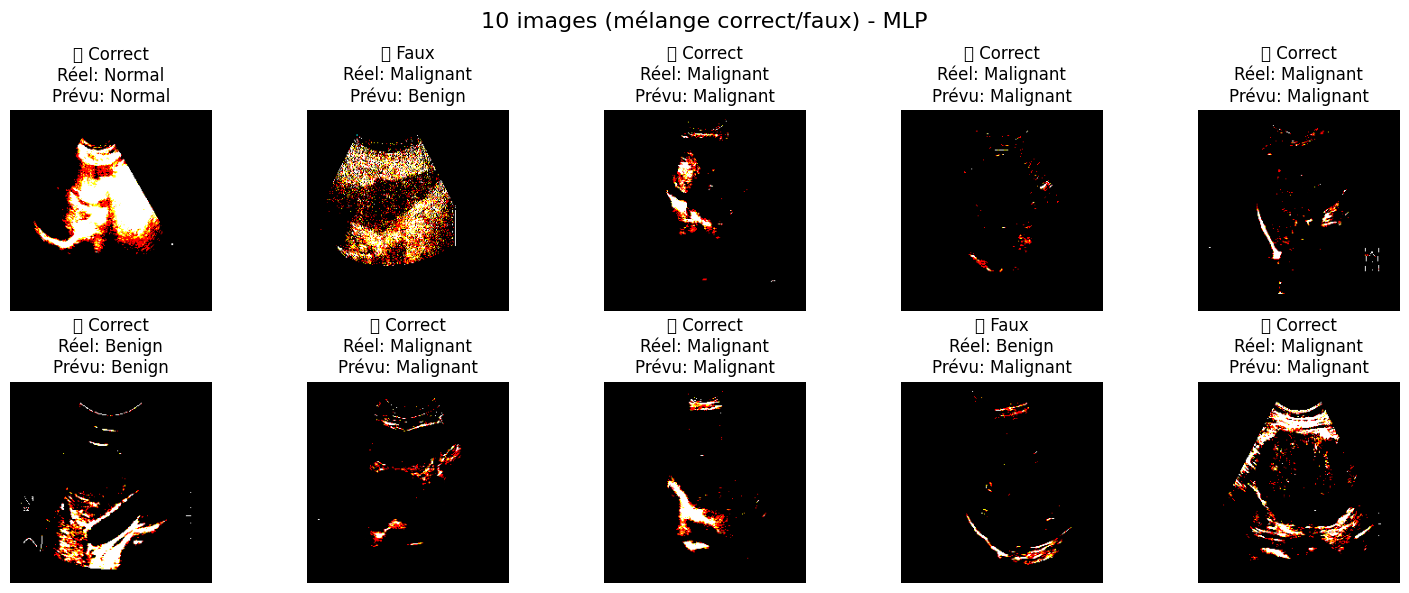

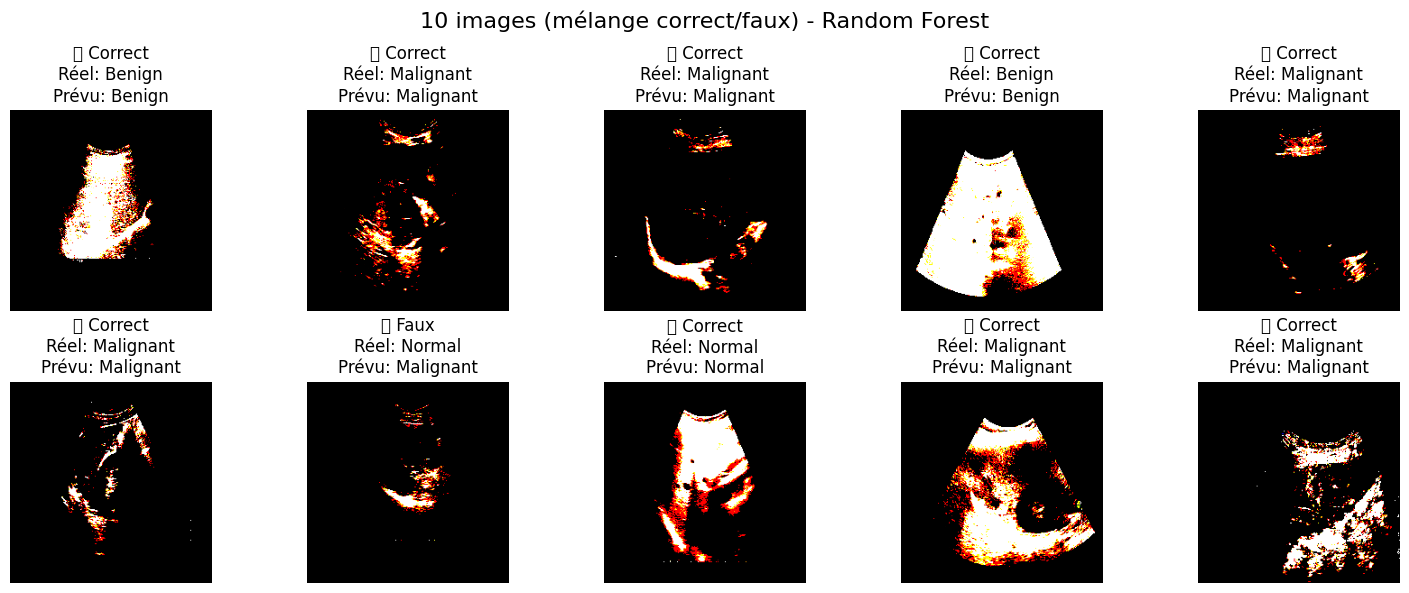

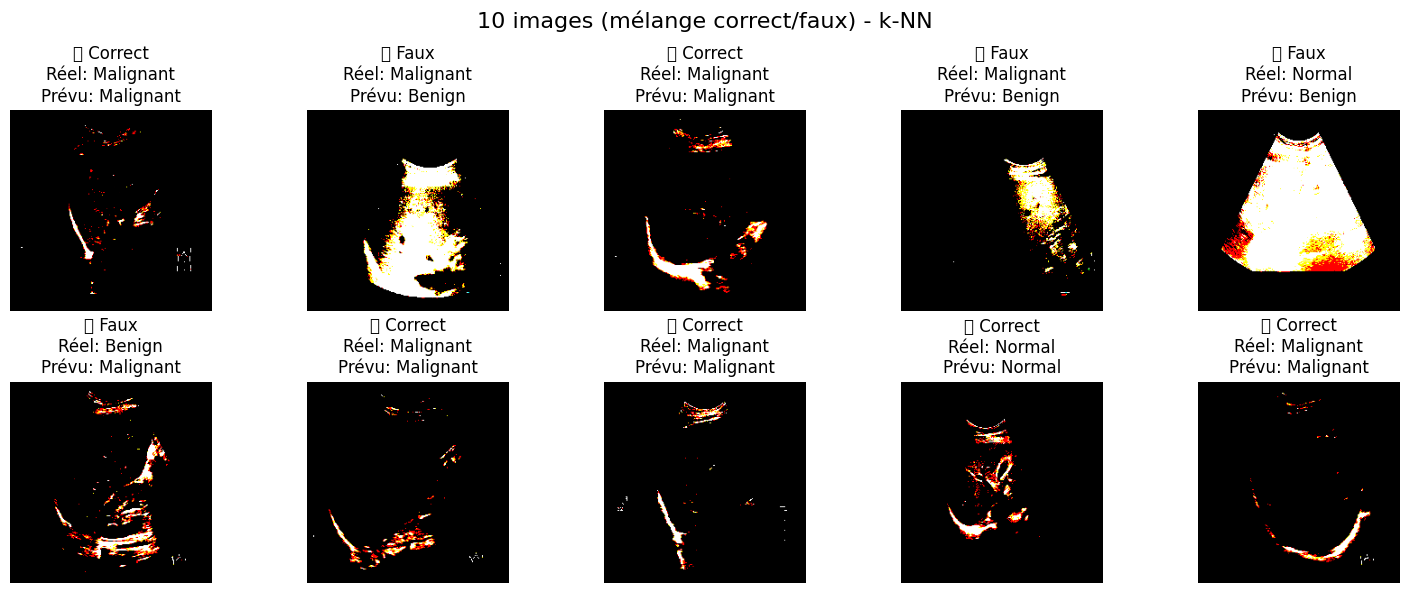

In [ ]:
# Exemple pour SVM
plot_predictions_mixed("SVM", y_test, y_pred, X_test, classes)

# Exemple pour MLP
plot_predictions_mixed("MLP", y_test, y_pred_mlp, X_test, classes)

# Exemple pour RF
plot_predictions_mixed("Random Forest", y_test, y_pred_rf, X_test, classes)

# Exemple pour k-NN
plot_predictions_mixed("k-NN", y_test, y_pred_knn, X_test, classes)


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Dictionnaire des modèles avec leurs prédictions
model_predictions = {
    "SVM": y_pred,
    "MLP": y_pred_mlp,
    "Random Forest": y_pred_rf,
    "k-NN": y_pred_knn,
}

# Création des listes
model_names = []
accuracies = []
f1_macros = []
precisions = []
recalls = []

# Remplir les métriques pour chaque modèle
for model_name, y_pred_model in model_predictions.items():
    model_names.append(model_name)
    accuracies.append(accuracy_score(y_test, y_pred_model))
    f1_macros.append(f1_score(y_test, y_pred_model, average='macro'))
    precisions.append(precision_score(y_test, y_pred_model, average='macro', zero_division=0))
    recalls.append(recall_score(y_test, y_pred_model, average='macro'))

# DataFrame final
results_df = pd.DataFrame({
    "Modèle": model_names,
    "Accuracy": accuracies,
    "F1-macro": f1_macros,
    "Précision": precisions,
    "Rappel": recalls
})

# Arrondir les résultats pour l'affichage
results_df = results_df.round(4)

# Affichage
print("📊 Résumé des performances des modèles :")
print(results_df)


📊 Résumé des performances des modèles :
          Modèle  Accuracy  F1-macro  Précision  Rappel
0            SVM    0.7207    0.6734     0.6721  0.6828
1            MLP    0.7387    0.7107     0.7423  0.6879
2  Random Forest    0.7297    0.6583     0.7244  0.6303
3           k-NN    0.7207    0.6523     0.6653  0.6485
